<a href="https://colab.research.google.com/github/sweeneyngo/furspect/blob/master/furspect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download images using simple_image_download
# Thanks Roy for multithreading
# Not sure if it requires Chrome + Webdriver
https://github.com/Roy6801/simple_image_download

# Download images using e621 downloader
# Compiled in Rust
# https://github.com/McSib/e621_downloader
# See PR/Issue
# fur rating:safe -human -animated -meme -comic -humanoid

**Loading dataset & directory setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
# Create a ZipFile Object and load dataset.zip
with ZipFile('drive/MyDrive/dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in dataset directory
   zipObj.extractall('dataset')

In [3]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

In [19]:
# create directories
dataset_home = 'dataset/dataset/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['furry/', 'notfurry/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [20]:
# seed random number generator
seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.20

# copy training dataset images into subdirectories
src_directory = dataset_home + 'furry/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	check = file.rsplit("_", 1)[1]
	if check.startswith('furry'):
		dst = dataset_home + dst_dir + 'furry/'  + file
		copyfile(src, dst)
  
src_directory = dataset_home + 'notfurry/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	check = file.rsplit("_", 1)[1]
	if check.startswith('notfurry'):
		dst = dataset_home + dst_dir + 'notfurry/'  + file
		copyfile(src, dst)

**Problem: Do we need to resize images to 200x200 before processing?**

In [ ]:
# flow_from_directory = iterative resizing/batch process --> slower, but less memory required
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
	class_mode='binary', batch_size=64, target_size=(200, 200))

**Develop a Baseline CNN Model**

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A good starting point is the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. For more details on the VGG model, see the 2015 paper “Very Deep Convolutional Networks for Large-Scale Image Recognition.”

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can explore this architecture on the dogs vs cats problem and compare a model with this architecture with 1, 2, and 3 blocks.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices. For example, a 3-block VGG-style architecture where each block has a single convolutional and pooling layer can be defined in Keras as follows:


In [24]:
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

**Relu Activation Function**
https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/



In [ ]:
	# convolutional layer block
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))

The model will be fit with stochastic gradient descent and we will start with a conservative learning rate of 0.001 and a momentum of 0.9.
An output layer with 1 node and a sigmoid activation will be used and the model will be optimized using the binary cross-entropy loss function.

In [ ]:
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

**Final model**

In [25]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

**Quick model set-up**

In [59]:
model = define_model()

Next, we need to prepare the data.

This involves first defining an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1.

In [60]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [61]:
import os
if '.ipynb_checkpoints' in os.listdir('dataset/dataset/test'):
  os.rmdir('dataset/dataset/test/.ipynb_checkpoints')

if '.ipynb_checkpoints' in os.listdir('dataset/dataset/train'):
  os.rmdir('dataset/dataset/train/.ipynb_checkpoints')

  
dir = os.listdir('dataset/dataset/test')
print(dir)
dir = os.listdir('dataset/dataset/train')
print(dir)

['furry', 'notfurry']
['furry', 'notfurry']


We can use the flow_from_directory() function on the data generator and create one iterator for each of the train/ and test/ directories. We must specify that the problem is a binary classification problem via the “class_mode” argument, and to load the images with the size of 200×200 pixels via the “target_size” argument. We will fix the batch size at 64.

In [62]:
# prepare iterators
train_it = datagen.flow_from_directory('dataset/dataset/train/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory('dataset/dataset/test/',
	class_mode='binary', batch_size=64, target_size=(200, 200))

Found 1990 images belonging to 2 classes.
Found 479 images belonging to 2 classes.


The number of steps for the train and test iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and test directories divided by the batch size (64).

The model will be fit for 20 epochs, a small number to check if the model can learn the problem.

In [63]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Once fit, the final model can be evaluated on the test dataset directly and the classification accuracy reported.

In [64]:
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0)) # 89.144 (1block) #94.154 (2block)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 94.154


The History contains the model accuracy and loss on the test and training dataset at the end of each epoch. Line plots of these measures over training epochs provide learning curves that we can use to get an idea of whether the model is overfitting, underfitting, or has a good fit.

The summarize_diagnostics() function below takes the history directory and creates a single figure with a line plot of the loss and another for the accuracy. The figure is then saved to file with a filename based on the name of the script. This is helpful if we wish to evaluate many variations of the model in different files and create line plots automatically for each.


In [65]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [66]:
summarize_diagnostics(history)

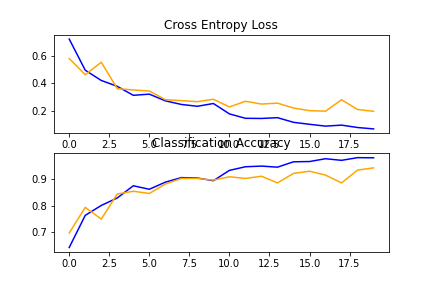

In [69]:
from IPython.display import Image, display
display(Image('ipykernel_launcher.py_plot.png'))

In [29]:
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset/dataset/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset/dataset/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [31]:
# entry point, run the test harness
run_test_harness()

Found 1990 images belonging to 3 classes.
Found 479 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


KeyboardInterrupt: ignored

In [58]:
# define cnn model (twoblock)
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model